In [38]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'GDX'  # gold
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_gdx.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(4566, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2006-05-22,36.520000,37.290001,35.869999,37.230000,32.197548,3.471890,1.019441,1.019608,1.013967
2006-05-23,37.750000,39.220001,37.750000,37.959999,32.828873,3.491308,1.005563,0.962065,0.978135
2006-05-24,37.130001,37.570000,35.869999,36.520000,31.583523,3.452636,0.983571,1.049288,1.018072
2006-05-25,37.180000,38.320000,36.980000,38.320000,33.140213,3.500747,1.030662,1.006002,1.010960
2006-05-26,38.740002,38.740002,37.770000,38.549999,33.339115,3.506731,0.995095,0.990143,1.024643
2006-05-30,39.500000,39.720001,38.110001,38.169998,33.010487,3.496825,0.966329,1.017815,1.019125
2006-05-31,38.900002,39.130001,38.119999,38.849998,33.598568,3.514483,0.998715,0.991763,0.957529
2006-06-01,37.200001,38.580002,37.169998,38.529999,33.321831,3.506213,1.035753,1.015572,1.020244
2006-06-02,39.310001,39.389999,38.799999,39.130001,33.840729,3.521665,0.995421,0.974444,1.029134


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2006-05-22    37.290001
2006-05-23    39.220001
2006-05-24    37.570000
2006-05-25    38.320000
2006-05-26    38.740002
                ...    
2024-07-08    36.160000
2024-07-09    36.369999
2024-07-10    37.169998
2024-07-11    38.150002
2024-07-12    38.310001
Name: high, Length: 4566, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2006-05-22')  # first day of legit open/close values
SIM_START

Timestamp('2006-05-22 00:00:00')

In [7]:
len(df.index >= SIM_START)

4566

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

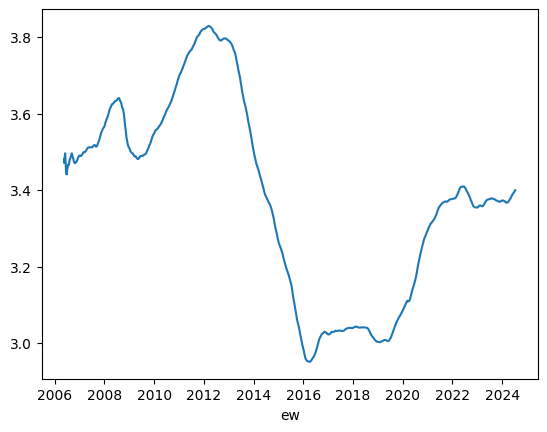

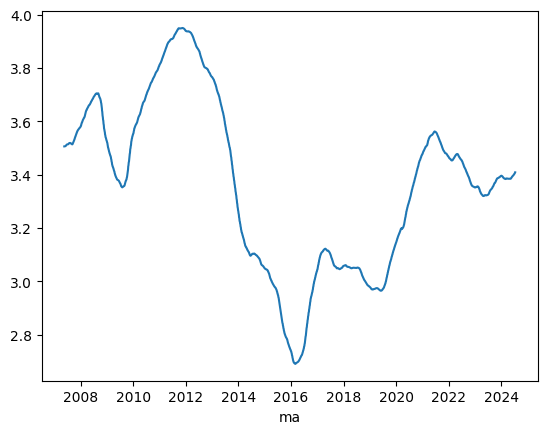

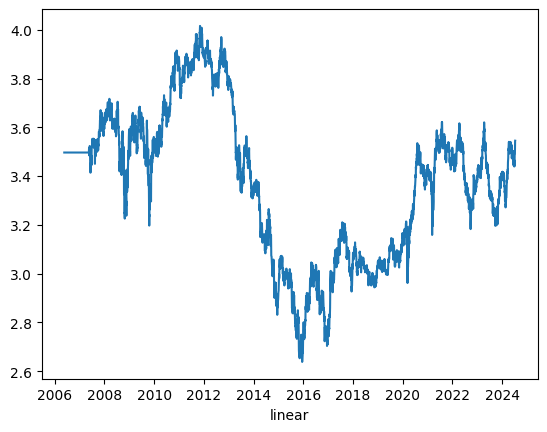

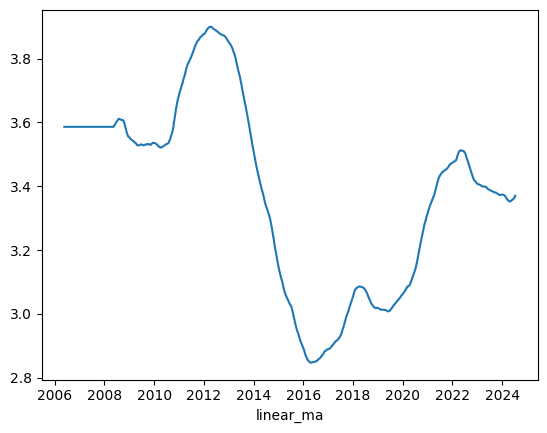

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(None, None)

Do nothing res: 1.1854939473204686
Round 1: 18.235158799004946
New best: 18.235158799004946
{'time_param': 81, 'method': 'ew', 't': 0.006109501514662274, 'k': 0.1041748038228121, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


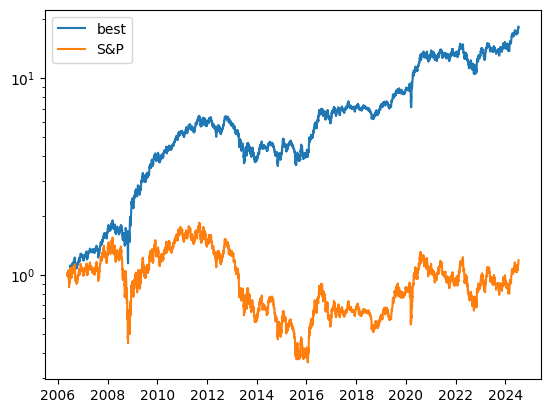

Round 2: 4.333121772498866
Round 3: 20.850507774855508
New best: 20.850507774855508
{'time_param': 194, 'method': 'linear_ma', 't': 0.34050944059733534, 'k': 0.12639678604503046, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


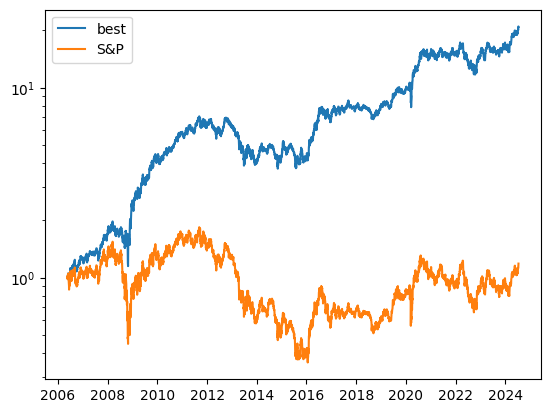

Round 4: 15.26005516307004
Round 5: nan
Round 6: 156.9914072060597
New best: 156.9914072060597
{'time_param': 58, 'method': 'ew', 't': 0.9673192577408626, 'k': 0.7420604718881165, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


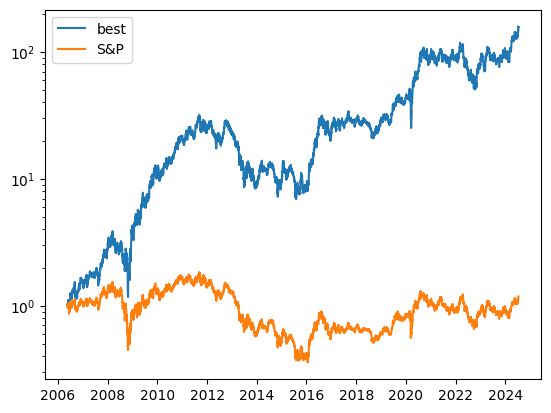

Round 7: 96.95378442349147
Round 8: 19.95383067965549
Round 9: 118.53303940251737
Round 10: nan
Round 11: nan
Round 12: 16.345219989463413
Round 13: nan
Round 14: nan
Round 15: 4.222164749952186
Round 16: 2.6737516206237175
Round 17: nan
Round 18: nan
Round 19: 2.507600175745095
Round 20: 141.08300954535932
Round 21: 2.7164595034462207
Round 22: 34.09109356361947
Round 23: nan
Round 24: 107.89191040947932
Round 25: 1.7913864065114697
Round 26: 48.06550373682506
Round 27: 6.769161457828267
Round 28: 133.65583668212253
Round 29: 16.383157628781277
Round 30: 14.945663751524085
Round 31: 220.00496788937787
New best: 220.00496788937787
{'time_param': 33, 'method': 'linear_ma', 't': 0.8852416515786286, 'k': 7.3087874009705525, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


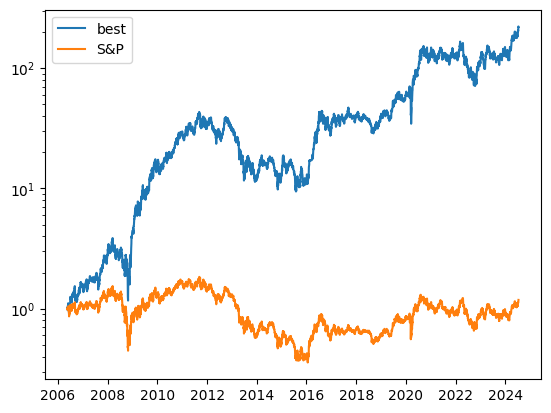

Round 32: nan
Round 33: 4.94110755991641
Round 34: 7.976199414771997
Round 35: 16.680571517073947
Round 36: 152.7942390980622
Round 37: nan
Round 38: nan
Round 39: 59.72033736894795
Round 40: nan
Round 41: 77.89940130683107
Round 42: nan
Round 43: nan
Round 44: 4.966945292520247
Round 45: 1.1933080191202898
Round 46: 45.01823397900975
Round 47: 20.545469265325785
Round 48: 155.21371056008297
Round 49: 142.95928906813222
Round 50: 8.937026227997563
Round 51: 39.7968937903902
Round 52: 60.59050885009093
Round 53: 8.670427839432204
Round 54: nan
Round 55: 4.219795108659138
Round 56: 20.179491258295123
Round 57: 27.058570897007034
Round 58: nan
Round 59: 59.159042360872135
Round 60: 19.08284190342108
Round 61: 10.855928018142961
Round 62: nan
Round 63: 18.81499719559364
Round 64: nan
Round 65: 26.137947570051416
Round 66: 105.9338345992526
Round 67: 163.1968553334788
Round 68: nan
Round 69: 7.124628270979976
Round 70: 22.212235583758783
Round 71: 129.14487535177517
Round 72: 24.40392456387

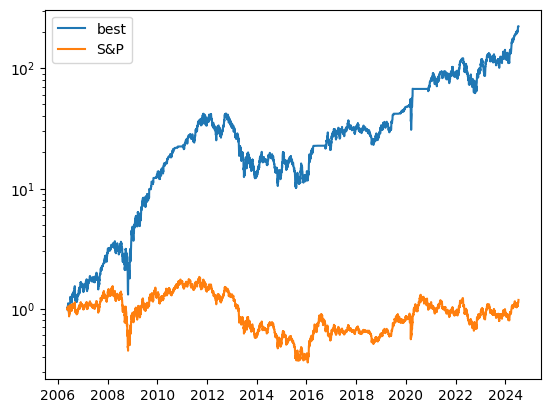

Round 86: nan
Round 87: nan
Round 88: 20.038525606070657
Round 89: nan
Round 90: 162.173612975908
Round 91: 9.629396909452616
Round 92: nan
Round 93: nan
Round 94: 161.28019400740527
Round 95: 113.03025613334007
Round 96: 145.76497106078995
Round 97: 41.9967435635387
Round 98: nan
Round 99: 36.81414031450561
Round 100: nan


In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 1.1854939473204686
Round 1: 178.35635288235778
Round 2: 171.76409109760874
Round 3: 75.40847419238101
Round 4: 108.45413861099301
Round 5: 223.62597573084605
New best: 223.62597573084605
{'time_param': 154, 'method': 'ew', 't': 0.7979806269785623, 'k': 6.250501426689272, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


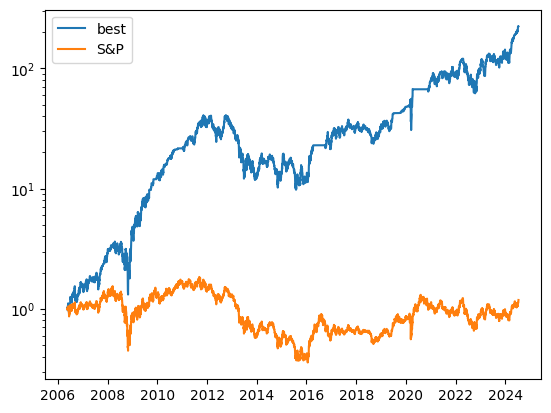

Round 6: 71.35898332606848
Round 7: 152.01868613899578
Round 8: 154.46904083439594
Round 9: 64.99286994616891
Round 10: 4.850128067344072
Round 11: 151.99492594558703
Round 12: 156.57938971788298
Round 13: 104.16879492255781
Round 14: 8.133571234884126
Round 15: 103.54667644814734
Round 16: 156.80642109508648
Round 17: 214.21861740987015
Round 18: 95.39903218566377
Round 19: 47.39099894224119
Round 20: 19.510965726439213
Round 21: 156.5679405708741
Round 22: 227.50295527901233
New best: 227.50295527901233
{'time_param': 161, 'method': 'ew', 't': 0.8758052597010619, 'k': 6.532451786383312, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


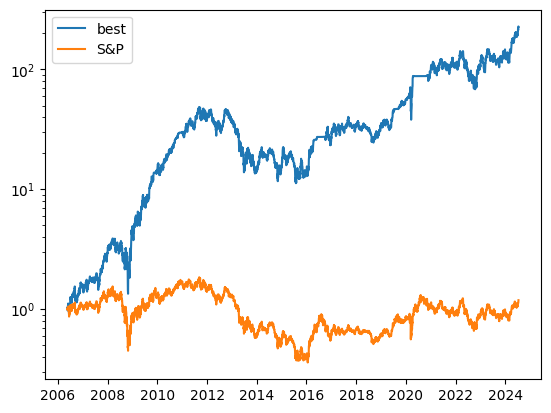

Round 23: 102.08615507841289
Round 24: 185.30371618318313
Round 25: 151.15680068368476

Factor: 1.03125
Do nothing res: 1.1854939473204686
Round 1: 171.08463054149945
Round 2: 102.20752688706868
Round 3: 152.43173563734194
Round 4: 150.5577401588684
Round 5: 112.8817895835448
Round 6: 151.12319002112557
Round 7: 147.39178618152187
Round 8: 151.18176421759148
Round 9: 152.39531467183193
Round 10: 151.16240857009112
Round 11: 151.1187254113609
Round 12: 83.47434604344791
Round 13: 240.13917154241787
New best: 240.13917154241787
{'time_param': 159, 'method': 'ew', 't': 0.8565506444228111, 'k': 6.498962474073532, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


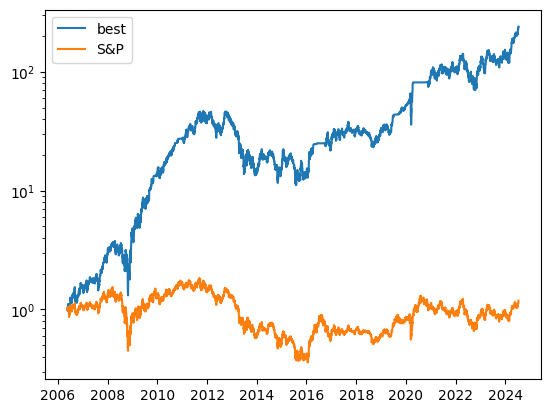

Round 14: 251.8787358927038
New best: 251.8787358927038
{'time_param': 162, 'method': 'ew', 't': 0.849787967077918, 'k': 6.4342552992038335, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


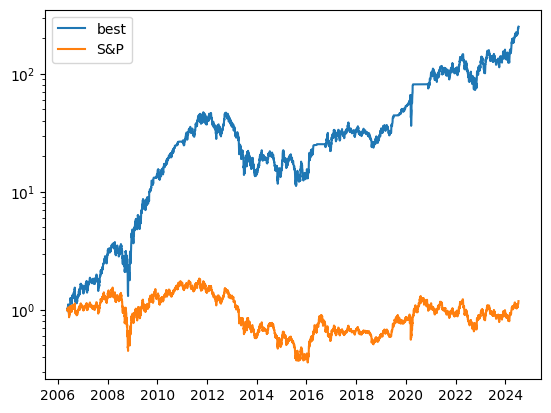

Round 15: 104.87785830823825
Round 16: 151.145838615692
Round 17: 15.239664056044141
Round 18: 103.38643649526064
Round 19: 23.06595367424514
Round 20: 197.0441795257435
Round 21: 152.43607608880896
Round 22: 229.14317406744013
Round 23: 219.43770124779823
Round 24: 152.4510936717673
Round 25: 162.13895585064336

Factor: 1.015625
Do nothing res: 1.1854939473204686
Round 1: 83.70432214674635
Round 2: 151.0465417782972
Round 3: 236.5474731539307
Round 4: 104.20534012148482
Round 5: 201.82182517316556
Round 6: 151.205691208606
Round 7: 28.078730822967813
Round 8: 1.5174083292261014
Round 9: 177.05981889351247
Round 10: 176.46620794409614
Round 11: 194.83803165736305
Round 12: 151.19538645178986
Round 13: 101.284683710101
Round 14: 151.16595939412687
Round 15: 151.16596329711874
Round 16: 209.453543051441
Round 17: 151.21087548010013
Round 18: 13.2965985437618
Round 19: 151.19553630008207
Round 20: 148.63343807224362
Round 21: 151.2035585090839
Round 22: 253.6905839507338
New best: 253.690

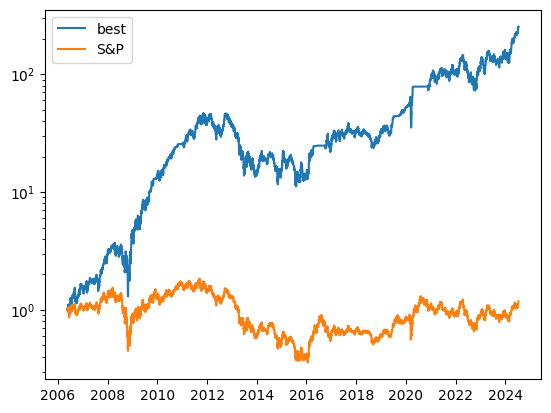

Round 23: 151.17682605928178
Round 24: 151.145374032873
Round 25: 104.15290027299967

Factor: 1.0078125
Do nothing res: 1.1854939473204686
Round 1: 101.3277954373175
Round 2: 110.60561674286396
Round 3: 151.1699801797737
Round 4: 151.1884209898372
Round 5: 52.774013582885935
Round 6: 82.56712401236398
Round 7: 151.1990657414868
Round 8: 151.18914942832194
Round 9: 107.76805435264461
Round 10: 234.78510865411994
Round 11: 151.18650073901108
Round 12: 217.8122104146236
Round 13: 157.5913148613509
Round 14: 151.16601644268144
Round 15: 1.5179144774978603
Round 16: 14.816545271149398
Round 17: 108.4091639645559
Round 18: 167.60453234065258
Round 19: 100.6219201117681
Round 20: 149.434271488369
Round 21: 132.46164974942457
Round 22: 102.41108181880925
Round 23: 102.18447421498722
Round 24: 231.1394688815836
Round 25: 151.15914691815578



In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [21]:
stop

NameError: name 'stop' is not defined

In [22]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [23]:
final_out = simulate(df, params_out)

In [24]:
amt_in = final_out['amt_in'][-1]
amt_in

0.004259501536929

In [25]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.9143483023001095

In [26]:
params_out

{'time_param': 162,
 'method': 'ew',
 't': 0.8399434985079146,
 'k': 6.416394305829154,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


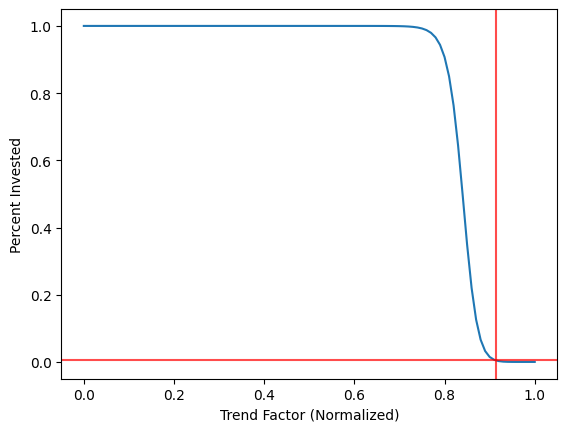

In [27]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

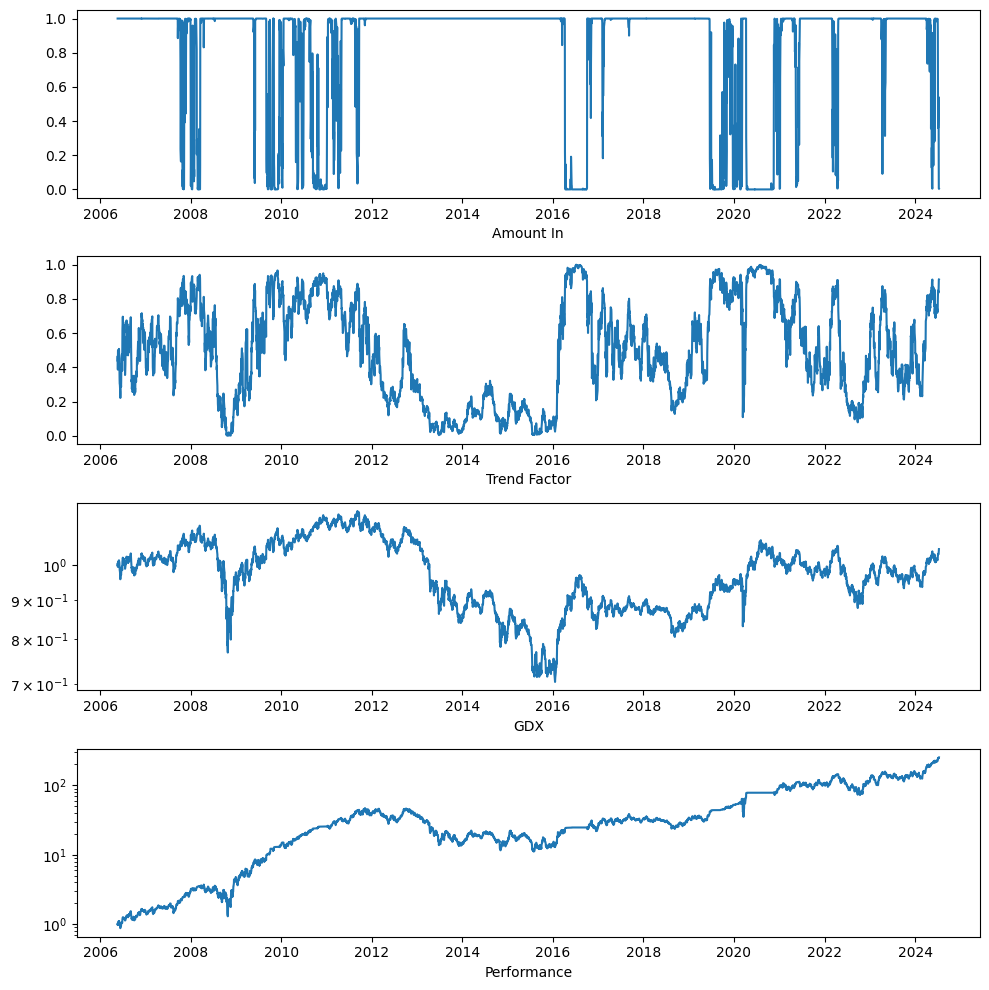

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

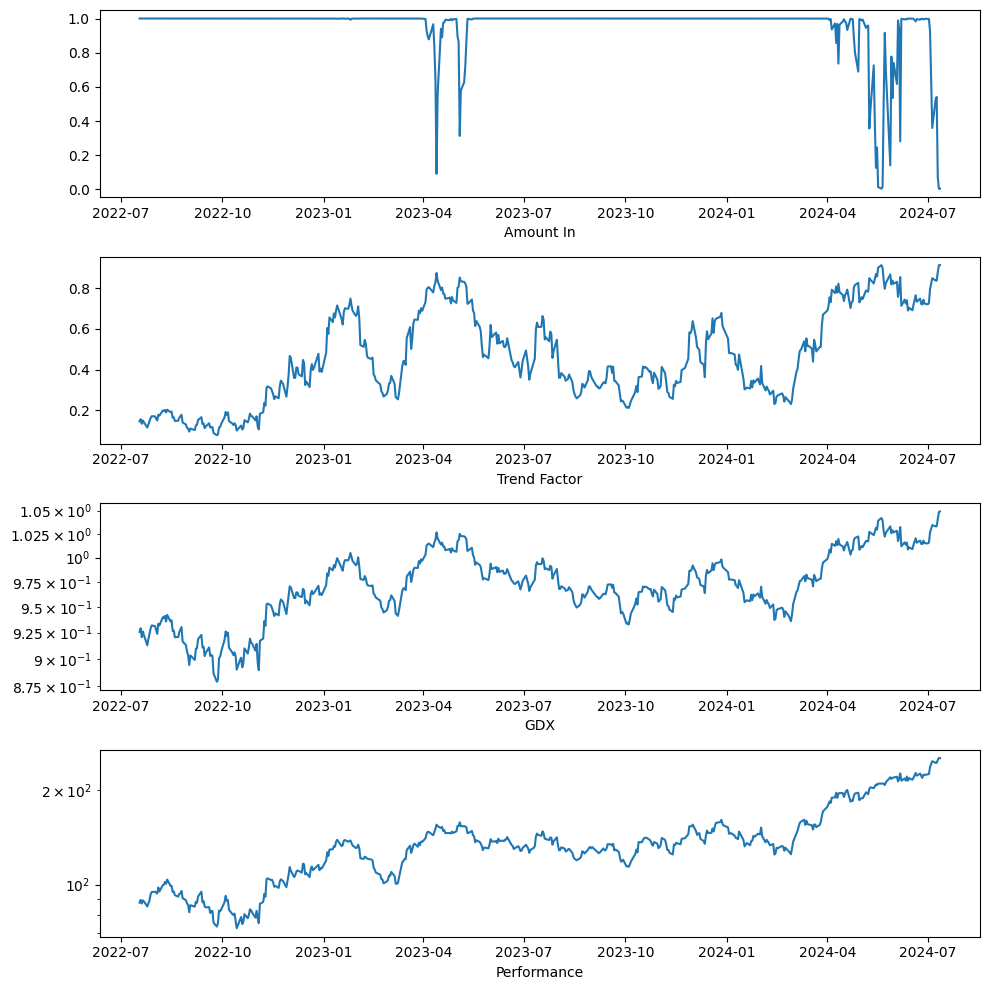

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [31]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(253.6905839507338,
 {'time_param': 162,
  'method': 'ew',
  't': 0.8399434985079146,
  'k': 6.416394305829154,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

In [39]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.0043

In [33]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(32.197547912597656, 18.264, 38.16999816894531)

In [35]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.3540718780854035

In [40]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['gdx'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.117876849072677, 0.9707], 'nas': [1.221824877675853, 0.9613], 'rus': [1.179140086085579, 0.7011], 'jpxn': [1.040675132153293, 0.4608], 'ktec': [1.6341335437597972, 0.0], 'emb': [1.0930267669763505, 0.9993], 'gdx': [1.3540718780854035, 0.0043]}


In [41]:
keys = ['sp', 'nas', 'rus', 'jpxn', 'ktec', 'emb', 'gdx']
rs = np.array([j[k][0] - 1 for k in keys])
rs

array([0.11787685, 0.22182488, 0.17914009, 0.04067513, 0.63413354,
       0.09302677, 0.35407188])

In [42]:
fracs_in = np.array([j[k][1]  for k in keys])
fracs_in

array([0.9707, 0.9613, 0.7011, 0.4608, 0.    , 0.9993, 0.0043])

In [44]:
#                   SPY,   FNCMX,  IWF, JPXN, KTEC, EMB, GDX
current = np.array([17917, 139638, 0,   0,    0,    0,   0])
cash = 30764
val = current.sum() + cash
target = (val * rs * fracs_in).round()
target

array([21548., 40157., 23652.,  3530.,     0., 17506.,   287.])

In [53]:
for k, diff in zip(keys, target - current):
    print(f'{k:4s}: {diff:7.0f}')

sp  :    3631
nas :  -99481
rus :   23652
jpxn:    3530
ktec:       0
emb :   17506
gdx :     287
